# It's Raining Cats and Dogs
   
##  Lab Assignment Three: Exploring Image Data 
   
### Justin Ledford, Luke Wood, Traian Pop

## Business Understanding

(10 points total).  
[10 points] Give an overview of the dataset. Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). Why is this data important and how will you know if you have gathered useful knowledge from the dataset? Be specific and use your own words to describe the aspects of the data.

The data set we are analyzing has over 25000 evenly distributed pictures of dogs and cats. We found it on https://www.kaggle.com/c/dogs-vs-cats and decided it would be a good set to practice processing and analyzing image data due to the clear classification metric of dogs|cats and the large number of high quality photos.
   
This data was originally collected for the purpose of a competition hosted by Kaggle to see who could create the most accurate algorithm that could distinguish between pictures of dogs and cats. Petfined.com are the original owners of the data, and they donated over 3 million pictures of sheltered animals that have been hand classified by them. Because of this, we are highly confident in the data, as the vast majority of humans can successfully identify between a dog and a cat. 
   
The competition itself is long over, but the page still remains for people to play and experiment with the data. This data is important due to potential it holds to help develop and train algorithms that could be used to evolve image recognition software. We can progressively check how useful the data we get from the set is by comparing it against our own classification and seeing if our own conclusions (i.e. if an image classifies a cat or not) match with the information we collect from it. 
   
We are not expecting perfect results as cats and dogs can look fairly similar at times, and the black and white color format of the pictures already limits easily differential characteristics between the two animals, such as fur color. However, we do believe that due to the large number and quality of the pictures, we can definitely expect to get a large amount of succesful results when processing and analyzing the data.

## Data Preparation 
(20 points total)

[5 points] Read in your images data as numpy arrays. Resize and recolor images as necessary. (DONE)
   
[10 points] Linearize the images to create a table of 1-D image features (each row should be one image). (DONE)
   
[5 points] Visualize several images. (DONE)
   


In [4]:
import numpy as np
from PIL import Image
import pandas as pd
import os
import glob
import plotly

#ignore warnings
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 


X = []
labels = []

# Image sizes
h, w = 150, 150 

for img_file in glob.iglob('data/*.jpg'):
    # Read in img as greyscale
    with Image.open(img_file).convert("L") as img:
        
        # Keep labels for each image in separate array
        if 'cat' in img_file:
            labels.append(0)
        else:
            labels.append(1)
        
        # Concatenate RGB into one row and collect
        X.append(np.concatenate(np.array(img)))
        
X = np.array(X)
labels = np.array(labels)


#convert to DF
df = pd.DataFrame(data=X, index=labels)

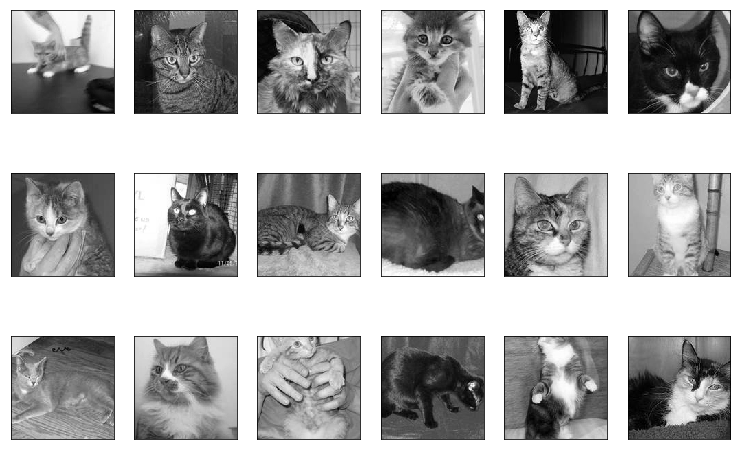

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# a helper plotting function (modified Larson's code)
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        #plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X, h, w) # defaults to showing a 3 by 6 subset of the faces

# Visualize some images
plt.show()

## Data Reduction 
(60 points total)

[10 points] Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component. How many dimensions are required to adequately represent your image data?
   
[10 points] Perform non-linear dimensionality reduction of your image data. Compare the representation using non-linear dimensions to using linear dimensions. Do you prefer one method over another? Why?
   
[20 points] Perform feature extraction upon the images using any feature extraction technique (e.g., gabor filters, ordered gradients, etc.).
   
[20 points] Visualize the differences between instances in each target class. For example, a heat map of the pairwise differences among all instances is likely appropriate for you data. Do you think the features extracted are appropriate for classification on your dataset? 


In [6]:
from sklearn.decomposition import PCA

n_components = 300
pca = PCA(n_components=n_components)
%time pca.fit(X)
eigens = pca.components_.reshape((n_components, h, w))

CPU times: user 22.6 s, sys: 1.24 s, total: 23.9 s
Wall time: 9.98 s


In [7]:
#plot_gallery(eigens, h, w)
#plt.show()

# Code by Larson, slightly changed to our data. Not final but cool to play with.

In [8]:
def plot_explained_variance(pca):
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

In [9]:
plot_explained_variance(pca)

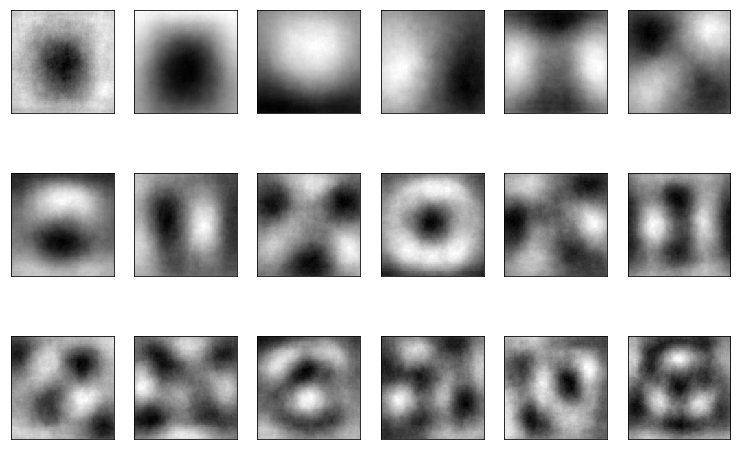

In [10]:
plot_gallery(eigens, h, w)

In [11]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image
    
idx_to_reconstruct = 4    
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X[idx_to_reconstruct])

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.



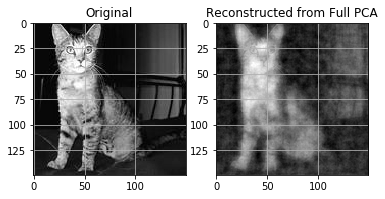

In [12]:
plt.subplot(1,2,1)
plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.grid()

plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')
plt.grid()

In [13]:
#randomized pca
from sklearn.decomposition import RandomizedPCA

n_components = 300
print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, X.shape[0]))

rpca = RandomizedPCA(n_components=n_components)
%time rpca.fit(X)
eigenfaces = rpca.components_.reshape((n_components, h, w))

Extracting the top 300 eigenfaces from 2000 faces


/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning:

Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.



CPU times: user 14 s, sys: 758 ms, total: 14.8 s
Wall time: 6.8 s


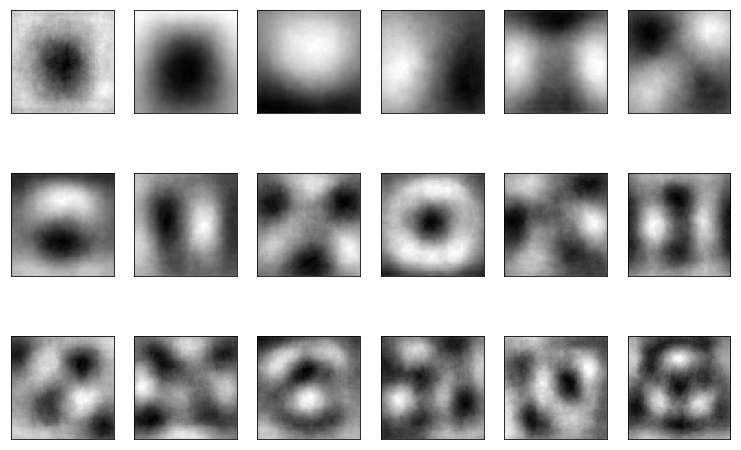

In [14]:
plot_gallery(eigenfaces, h, w)

In [15]:
#kernel
from sklearn.decomposition import KernelPCA

n_components = 300
print ("Extracting the top %d eigenfaces from %d faces" % (n_components, X.shape[0]))

kpca = KernelPCA(n_components=n_components, kernel='rbf', 
                fit_inverse_transform=True, gamma=15) # very sensitive to the gamma parameter
%time kpca.fit(X)


Extracting the top 300 eigenfaces from 2000 faces
CPU times: user 20.7 s, sys: 684 ms, total: 21.4 s
Wall time: 8.94 s


KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=15, kernel='rbf',
     kernel_params=None, max_iter=None, n_components=300, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)

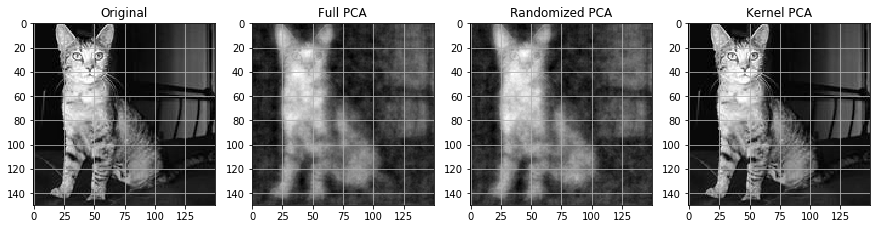

In [16]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

from ipywidgets import widgets  # make this interactive!
# compare the different methods

def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    reconstructed_image = pca.inverse_transform(pca.transform(X[idx_to_reconstruct]))
    reconstructed_image_rpca = rpca.inverse_transform(rpca.transform(X[idx_to_reconstruct]))
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(X[idx_to_reconstruct]))
    
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,4,1)
    plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Original')
    plt.grid()
    
    plt.subplot(1,4,2)
    plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Full PCA')
    plt.grid()
    
    plt.subplot(1,4,3)
    plt.imshow(reconstructed_image_rpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Randomized PCA')
    plt.grid()
    
    plt.subplot(1,4,4)
    plt.imshow(reconstructed_image_kpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Kernel PCA')
    plt.grid()

plt_reconstruct(4)
#widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,n_samples-1,1),__manual=True)

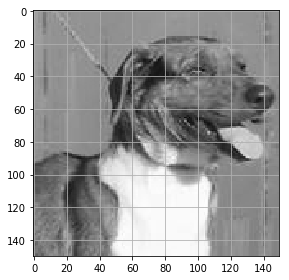

In [17]:
#image processing
from skimage.io import imshow

idx_to_reconstruct = int(np.random.rand(1)*len(X))
img  = X[idx_to_reconstruct].reshape((h,w))
imshow(img)
plt.grid()

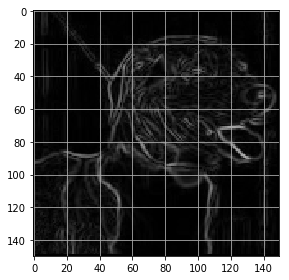

In [18]:
from skimage.filters import sobel_h, sobel_v

gradient_mag = np.sqrt(sobel_v(img)**2 + sobel_h(img)**2 ) 
imshow(gradient_mag)
plt.grid()

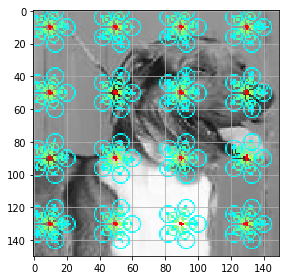

In [19]:
#daisy
from skimage.feature import daisy

# lets first visualize what the daisy descripto looks like
features, img_desc = daisy(img,step=40, radius=10, rings=3, histograms=5, orientations=8, visualize=True)
imshow(img_desc)
plt.grid()

In [20]:
# now let's understand how to use it
features = daisy(img,step=10, radius=10, rings=2, histograms=4, orientations=8, visualize=False)
print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2])

(13, 13, 72)
12168


In [21]:
# create a function to tak in the row of the matric and return a new feature
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),step=10, radius=10, rings=2, histograms=6, orientations=8, visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(X[3],(h,w))
test_feature.shape

CPU times: user 40 ms, sys: 7.87 ms, total: 47.9 ms
Wall time: 48.1 ms


(17576,)

In [22]:
0.019 * len(X) # approximate how long it may run

38.0

In [27]:
# apply to entire data, row by row,
# takes about a minute to run
%time daisy_features = np.apply_along_axis(apply_daisy, 1, X, (h,w))
print(daisy_features.shape)

CPU times: user 1min 10s, sys: 9.46 s, total: 1min 20s
Wall time: 1min 22s
(2000, 17576)


In [28]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)

CPU times: user 4.75 s, sys: 53.6 ms, total: 4.8 s
Wall time: 1.57 s


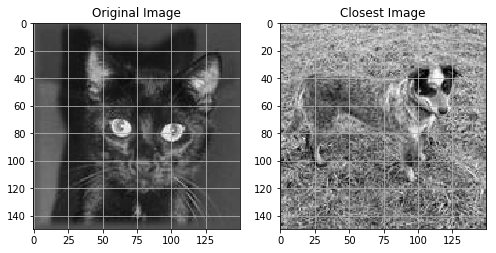

In [29]:
import copy
# find closest image to current image
idx1 = 112
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(X[idx1].reshape((h,w)))
plt.title("Original Image")
plt.grid()

plt.subplot(1,2,2)
imshow(X[idx2].reshape((h,w)))
plt.title("Closest Image")
plt.grid()

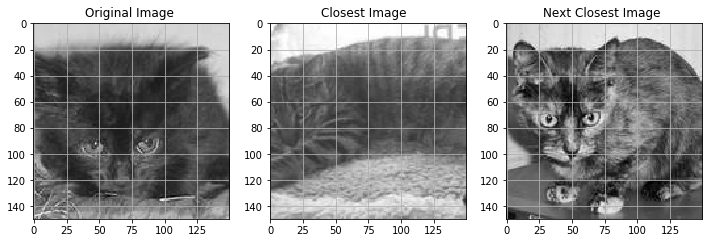

In [30]:
from ipywidgets import fixed
from ipywidgets import widgets  # make this interactive!

# put it together inside a nice widget
def closest_image(dmat,idx1):
    distances = copy.deepcopy(dmat[idx1,:]) # get all image distances
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    
    distances[idx2] = np.infty
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(10,16))
    plt.subplot(1,3,1)
    imshow(X[idx1].reshape((h,w)))
    plt.title("Original Image ")
    plt.grid()

    plt.subplot(1,3,2)
    imshow(X[idx2].reshape((h,w)))
    plt.title("Closest Image  ")
    plt.grid()
    
    plt.subplot(1,3,3)
    imshow(X[idx3].reshape((h,w)))
    plt.title("Next Closest Image ")
    plt.grid()

#closest_image(idx1)
widgets.interact(closest_image,idx1=(0,1500-1,1),dmat=fixed(dist_matrix),__manual=True)

In [31]:
#garbor
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats

# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

            
# compute the filter bank and take statistics of image
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
        # mean, var, skew, kurt
        
    return feats.reshape(-1)

idx_to_reconstruct = int(np.random.rand(1)*len(X))

gabr_feature = compute_gabor(X[idx_to_reconstruct], kernels, (h,w))
gabr_feature

array([  1.80314044e+02,   3.58009631e+03,  -1.56658308e+00,
         1.35004698e+00,   5.48818667e+01,   3.72747233e+02,
        -1.05255177e+00,   5.55611858e+00,   1.21468800e+02,
         1.48566172e+03,  -1.53606648e+00,   1.38767517e+00,
         2.21348889e+01,   5.07268641e+03,   2.94680963e+00,
         6.68598111e+00,   1.80315644e+02,   3.58017869e+03,
        -1.56655934e+00,   1.34999966e+00,   5.49068000e+01,
         3.64856641e+02,  -1.27542959e+00,   3.81863884e+00,
         1.22524400e+02,   1.51005350e+03,  -1.52955003e+00,
         1.35326012e+00,   1.97466222e+01,   4.59900762e+03,
         3.17021636e+00,   8.05144235e+00,   1.80317378e+02,
         3.57997994e+03,  -1.56649907e+00,   1.34988444e+00,
         5.51443556e+01,   4.08098721e+02,   2.55604370e-02,
         1.33278493e+01,   1.21462400e+02,   1.48483902e+03,
        -1.52565836e+00,   1.34246180e+00,   2.36540000e+01,
         5.39275361e+03,   2.81921073e+00,   5.94976177e+00,
         1.80315778e+02,

In [33]:
# takes ~3 minutes to run entire dataset
%time gabor_stats = np.apply_along_axis(compute_gabor, 1, X, kernels, (h,w))
print(gabor_stats.shape)

CPU times: user 3min 36s, sys: 3.91 s, total: 3min 40s
Wall time: 4min 8s
(2000, 64)


In [34]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(gabor_stats)

CPU times: user 86.1 ms, sys: 23.5 ms, total: 110 ms
Wall time: 147 ms


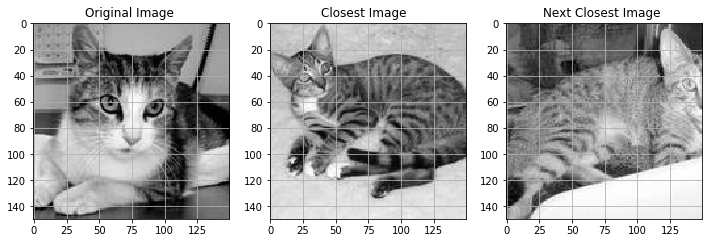

In [36]:
widgets.interact(closest_image,idx1=(0,1500-1,1),dmat=fixed(dist_matrix),__manual=True)